/kaggle/input/fer2013.csv
Data Distribution
Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64
Samples/emotion:
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64
pixels/sample:
2304


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:55: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


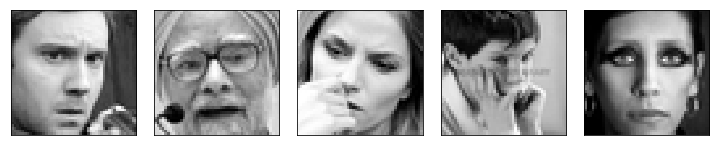

training VGG


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 29068 samples, validate on 3230 samples
Epoch 1/10
 - 36s - loss: 1.3361 - acc: 0.4901 - val_loss: 1.2140 - val_acc: 0.5396
Epoch 2/10
 - 28s - loss: 1.1116 - acc: 0.5817 - val_loss: 1.1251 - val_acc: 0.5687
Epoch 3/10
 - 27s - loss: 1.0007 - acc: 0.6235 - val_loss: 1.0920 - val_acc: 0.5817
Epoch 4/10
 - 28s - loss: 0.9160 - acc: 0.6593 - val_loss: 1.0617 - val_acc: 0.6077
Epoch 5/10
 - 27s - loss: 0.8360 - acc: 0.6891 - val_loss: 0.9968 - val_acc: 0.6260
Epoch 6/10
 - 28s - loss: 0.7536 - acc: 0.7247 - val_loss: 1.0367 - val_acc: 0.6245
Epoch 7/10
 - 27s - loss: 0.6666 - acc: 0.7569 - val_loss: 1.0926 - val_acc: 0.6235
Epoch 8/10
 - 28s - loss: 0.5702 - acc: 0.7926 - val_loss: 1.1226 - val_acc: 0.6341
Epoch 9/10
 - 28s - loss: 0.4771 - acc: 0.8309 - val_loss: 1.2104 - val_acc: 0.6279
Epoch 10/10
 - 27s - loss: 0.3933 - acc: 0.8592 - val_loss: 1.3004 - val_acc: 0.6393
3589/3589 [==============================] - 5s 1ms/step
Loss1.3303750075480838
Accuracy0.6414042908971308
tra

In [3]:

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import cv2 
from keras.losses import categorical_crossentropy
from keras.optimizers import SGD


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
data= pd.read_csv('../input/fer2013.csv')


height,width,depth = 48,48,1

data.head()

print("Data Distribution")
print(data.Usage.value_counts())

print('Samples/emotion:')
print(data.emotion.value_counts())

print('pixels/sample:')
print(len(data.pixels[0].split(' ')))

emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
num_classes = len(emotion_labels)

def convert_fer2013(data):
    pixels = data['pixels'].tolist()

    faces = []
    for pixel_sq in pixels:
        face = [int(pixel) for pixel in pixel_sq.split(' ')]
        face = np.asarray(face).reshape(width, height)
        face = cv2.resize(face.astype('uint8'), (width, height))
        face = np.stack((face,)*3, -1)
        faces.append(face.astype('float32'))

    faces = np.asarray(faces)
    emotions = pd.get_dummies(data['emotion']).as_matrix()

    return faces, emotions

X, y = convert_fer2013(data)


def normalize(imgs):
    new_imgs = []
    for img in imgs:
        img = img / 255.0
        new_imgs.append(img)

    return new_imgs

X = np.array(normalize(X))


def overview(start, end, X):
    fig = plt.figure(figsize=(20,20))
    for i in range(start, end):
        input_img = X[i:(i+1),:,:,:]
        ax = fig.add_subplot(10,10,i+1)
        ax.imshow(input_img[0,:,:,0], cmap=matplotlib.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
    plt.show()
overview(0,5, X)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.1,
                                                    random_state=41)

def transfer_learning(model):
    for layer in model.layers:
        layer.trainable = False
        
model_vgg = VGG16(include_top=False,
              weights='imagenet',
              pooling='avg')
model_resnet = ResNet50(include_top=False,
              weights='imagenet',
              pooling='avg')
model_inception = InceptionV3(include_top=False,
              weights='imagenet',
              pooling='avg')

models = [model_vgg,model_resnet,model_inception]
model_name = ["VGG","RESNET","GoogleNet"]

def training_model(para):
#     i =0;
#     for model in models:
    #print("Training model " + model_name[i])
    model = para;
    x = model.output

    y = Dense(num_classes,
            activation='softmax')(x)

    final_model = Model(input=model.input,
                                output=y)
        
    opt = SGD(lr=0.0005, momentum=0.9, nesterov=True)

    final_model.compile(optimizer=opt,
                                loss=categorical_crossentropy,
                                metrics=['accuracy'])


    final_model.fit(X_train, y_train,
                        batch_size=32,
                            epochs=10,
                            validation_split=0.1,
                            shuffle=True,
                            verbose=2)

    for layer in final_model.layers[4:]:
        layer.trainable = True

    final_model.compile(optimizer=opt,
                                loss=categorical_crossentropy,
                                metrics=['accuracy'])
    scores = final_model.evaluate(X_test, y_test,
                                  batch_size=32)

    print("Loss"+ str(scores[0]))
    print("Accuracy"+ str(scores[1]))
#             i=i+1;
        
print("training VGG")
training_model(model_vgg)
print("training Resnet")
training_model(model_resnet)

